Functions

In [12]:
### Functions

# ML PIPELINE

# 1. DATA INGESTION (READING IN DATA)
## Process of collecting data in code block below 

# 2. DATA CLEANING
## Function to group data in 'Other' category if less than a certain percentage of total
def bin_groups(df, percent):
    import pandas as pd
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            for group, count in df[col].value_counts().iteritems():
                if count / len(df) < percent:
                    df.loc[df[col] == group, col] = 'Other'
    return df


## drop columns that are missing a certain percentage of data
def drop_columns_missing_data(df, cutoff):
    for col in df:
        if df[col].isna().sum() / len(df) > cutoff:
            df.drop(columns=[col], inplace=True)
    return df

## function to split datetime into time of day, day of the week, and month 
# We found that these new values did not help our model, so this function is never used.
def convert_datetime(df):
    import pandas as pd
    from datetime import datetime as dt

    pd.set_option('mode.chained_assignment', None)

    # df['crash_time'] = pd.to_datetime(df['CRASH_DATETIME']).dt.hour.astype(str)
    df['crash_weekday'] = pd.to_datetime(df['CRASH_DATETIME']).dt.weekday.astype(str)
    df['crash_month'] = pd.to_datetime(df['CRASH_DATETIME']).dt.month.astype(str)

    df.drop(columns=['CRASH_DATETIME'])

    return df

## Get dummy codes from remaining categorical features
def get_dummy_codes(df):
    import pandas as pd

    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    return df

## convert to float datatype for onnx (run after get_dummy_codes)
def convert_float(df):
    import pandas as pd

    # all the data should be int when this code is run
    for col in df:
        df[col] = df[col].astype('float64')
        # df[col] = float(df[col])

    return df

# 3. MODEL DATA

# run xgboost model. We ultimately decided that this model would be best for our predictions

def pipeline_xgboost(df,label):
    X = df.drop(columns=[label])
    y = df[label]

    pipe = Pipeline([('scaler', StandardScaler()),
                    ('xgb', XGBClassifier(n_estimators=5,objective='multi:softmax'))])

    pipe.fit(X, y)

    return pipe

def fit_xgboost(df, label, k=10, r=5, repeat=True):
    import sklearn.linear_model as lm, pandas as pd, sklearn.ensemble as se, numpy as np
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    from numpy import mean
    from xgboost import XGBClassifier
    from sklearn import preprocessing
    from sklearn.neural_network import MLPClassifier

    X = df.drop(columns=[label])
    y = df[label]

    if repeat:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
    else:
        cv = KFold(n_splits=k, random_state=12345, shuffle=True)
    
    fit = {}    # Use this to store each of the fit metrics
    models = {} # Use this to store each of the models

    # Create the model objects
    model_xgb = XGBClassifier()

    # Fit a crss-validated R squared score and add it to the dict
    fit['XGBoost'] = mean(cross_val_score(model_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))

    # Add the model to another dict; make sure the keys have the same names as the list above
    models['XGBoost'] = model_xgb

    # Add the fit dictionary to a new DataFrame, sort, extract the top row, use it to retrieve the model object from the models dictionary
    df_fit = pd.DataFrame({'Accuracy':fit})
    df_fit.sort_values(by=['Accuracy'], ascending=False, inplace=True)
    best_model = df_fit.index[0]
    print(df_fit)

    return models[best_model].fit(X, y)


## runs a voting model, the model we initially thought to be the best for our data

def fit_voting(df, label, k=10, r=5, repeat=True):
    import sklearn.linear_model as lm, pandas as pd, sklearn.ensemble as se, numpy as np
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    from numpy import mean, std
    from sklearn import svm
    from sklearn import gaussian_process
    from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    from sklearn import svm
    from sklearn.naive_bayes import CategoricalNB
    from xgboost import XGBClassifier
    from sklearn import preprocessing
    from sklearn.neural_network import MLPClassifier

    X = df.drop(columns=[label])
    y = df[label]

    if repeat:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
    else:
        cv = KFold(n_splits=k, random_state=12345, shuffle=True)
    
    fit = {}    # Use this to store each of the fit metrics
    models = {} # Use this to store each of the models

    # Create the model objects
    model_log = lm.LogisticRegression(max_iter=100) 
    model_ext = se.ExtraTreesClassifier(n_estimators=100, random_state=12345)
    model_hgb = se.HistGradientBoostingClassifier(max_iter=100)
    model_vot = se.VotingClassifier(estimators=[('lr', model_log), ('rf', model_ext), ('gnb', model_hgb)], voting='hard', flatten_transform=True)

    # Fit a crss-validated R squared score and add it to the dict
    fit['Voting'] = mean(cross_val_score(model_vot, X, y, scoring='accuracy', cv=cv, n_jobs=-1))

    # Add the model to another dict; make sure the keys have the same names as the list above
    models['Voting'] = model_vot

    # Add the fit dictionary to a new DataFrame, sort, extract the top row, use it to retrieve the model object from the models dictionary
    df_fit = pd.DataFrame({'Accuracy':fit})
    df_fit.sort_values(by=['Accuracy'], ascending=False, inplace=True)
    best_model = df_fit.index[0]
    print(df_fit)

    return models[best_model].fit(X, y)



# 4. DEPLOY MODEL

## Save model
### pickle and joblib are two different packages you can use to save and load your models
def dump_pickle(model, file_name):
    import pickle
    pickle.dump(model, open(file_name, "wb"))

def dump_joblib(model, file_name):
    import joblib
    joblib.dump(model, file_name)

# Load models
def load_pickle(file_name):
    import pickle
    model = pickle.load(open(file_name, "rb"))
    return model
    
def load_joblib(file_name):
    import joblib
    model = joblib.load(file_name)
    return model

In [4]:
# Get rid of any features that have a low variance
# Low variance is bad because it means they dont have any potential to explain the label variance

def fs_variance(df, label="", p=0.8):
    from sklearn.feature_selection import VarianceThreshold
    import pandas as pd

    if label != "":
        X = df.drop(columns=[label])
        
    sel = VarianceThreshold(threshold=(p * (1 - p)))
    sel.fit_transform(X)

    # Add the label back in after removing poor features
    return df[sel.get_feature_names_out()].join(df[label])


### Decision Trees Recursive Function
def fs_select_trees(df, label):
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.feature_selection import SelectFromModel
    import pandas as pd

    X = df.drop(columns=[label])
    y = df[label]

    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X, y)
    sel = SelectFromModel(clf, prefit=True)
    sel.transform(X)

    columns = list(X.columns[sel.get_support()])
    columns.append(label)
    return df[columns]

def fs_kbest(df, k=10, label=""):
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import r_regression
    import pandas as pd

    X = df.drop(columns=[label])
    y = df[label]

    # Select the top k features based on a given bivariate metric
    sel = SelectKBest(r_regression, k=k)
    sel.fit_transform(X, y)

    return df[sel.get_feature_names_out()].join(df[label])

In [5]:
### Finding the best Model for Classification
## We used this function to find the best model for our data. We then created the 'fit_voting' function for tweaking purposes

def fit_crossvalidate_all_clf(df, label, k=10, r=5, repeat=True):
    import sklearn.linear_model as lm, pandas as pd, sklearn.ensemble as se, numpy as np
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    from numpy import mean, std
    from sklearn import svm
    from sklearn import gaussian_process
    from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    from sklearn import svm
    from sklearn.naive_bayes import CategoricalNB
    from xgboost import XGBClassifier
    from sklearn import preprocessing
    from sklearn.neural_network import MLPClassifier

    X = df.drop(columns=[label])
    y = df[label]

    if repeat:
        cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=12345)
    else:
        cv = KFold(n_splits=k, random_state=12345, shuffle=True)
    
    fit = {}    # Use this to store each of the fit metrics
    models = {} # Use this to store each of the models

    # Create the model objects
    model_log = lm.LogisticRegression(max_iter=100) # binary clf model
    model_logcv = lm.RidgeClassifier()
    model_sgd = lm.SGDClassifier(max_iter=1000, tol=1e-3)
    model_pa = lm.PassiveAggressiveClassifier(max_iter=1000, random_state=12345, tol=1e-3)
    model_per = lm.Perceptron(fit_intercept=False, max_iter=10, tol=None, shuffle=False)
    model_knn = KNeighborsClassifier(n_neighbors=3)
    model_svm = svm.SVC(decision_function_shape='ovo') # Remove the parameter for two-class model
    model_nb = CategoricalNB()
    model_bag = se.BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
    model_ada = se.AdaBoostClassifier(n_estimators=100, random_state=12345)
    model_ext = se.ExtraTreesClassifier(n_estimators=100, random_state=12345)
    model_rf = se.RandomForestClassifier(n_estimators=10)
    model_hgb = se.HistGradientBoostingClassifier(max_iter=100)
    model_vot = se.VotingClassifier(estimators=[('lr', model_log), ('rf', model_ext), ('gnb', model_hgb)], voting='hard', flatten_transform=True)
    model_gb = se.GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    estimators = [('ridge', lm.RidgeCV()), ('lasso', lm.LassoCV(random_state=12345)), ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean'))]
    final_estimator = se.GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=12345)
    model_st = se.StackingRegressor(estimators=estimators, final_estimator=final_estimator)
    model_xgb = XGBClassifier()
    model_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=12345)

    # Fit a crss-validated R squared score and add it to the dict
    fit['Logistic'] = mean(cross_val_score(model_log, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Ridge'] = mean(cross_val_score(model_logcv, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['SGD'] = mean(cross_val_score(model_sgd, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['PassiveAggressive'] = mean(cross_val_score(model_pa, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Perceptron'] = mean(cross_val_score(model_per, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['KNN'] = mean(cross_val_score(model_knn, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['SVM'] = mean(cross_val_score(model_svm, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['NaiveBayes'] = mean(cross_val_score(model_nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Bagging'] = mean(cross_val_score(model_bag, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['AdaBoost'] = mean(cross_val_score(model_ada, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['ExtraTrees'] = mean(cross_val_score(model_ext, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['RandomForest'] = mean(cross_val_score(model_rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['HistGradient'] = mean(cross_val_score(model_hgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Voting'] = mean(cross_val_score(model_vot, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['GradBoost'] = mean(cross_val_score(model_gb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['XGBoost'] = mean(cross_val_score(model_xgb, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['NeuralN'] = mean(cross_val_score(model_nn, X, y, scoring='accuracy', cv=cv, n_jobs=-1))

    # Add the model to another dict; make sure the keys have the same names as the list above
    models['Logistic'] = model_log
    models['Ridge'] = model_logcv
    models['SGD'] = model_sgd
    models['PassiveAggressive'] = model_pa
    models['Perceptron'] = model_per
    models['KNN'] = model_knn
    models['SVM'] = model_svm
    models['NaiveBayes'] = model_nb
    models['Bagging'] = model_bag
    models['AdaBoost'] = model_ada
    models['ExtraTrees'] = model_ext
    models['RandomForest'] = model_rf
    models['HistGradient'] = model_hgb
    models['Voting'] = model_vot
    models['GradBoost'] = model_gb
    models['XGBoost'] = model_xgb
    models['NeuralN'] = model_nn

    # Add the fit dictionary to a new DataFrame, sort, extract the top row, use it to retrieve the model object from the models dictionary
    df_fit = pd.DataFrame({'Accuracy':fit})
    df_fit.sort_values(by=['Accuracy'], ascending=False, inplace=True)
    best_model = df_fit.index[0]
    print(df_fit)

    return models[best_model].fit(X, y)

Part 1: Data Ingestion

In [6]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("opendata.utah.gov", None)

# Example authenticated client (needed for non-public datasets):
client = Socrata("opendata.utah.gov",
                 "pKV6mTaHiRtVlotxN1ghwXMx9",
                 "brittan.hunter@gmail.com",
                 "IS455group49#3!k")

# grabs data from 2016, 2017, and 2019
results = client.get("herb-zqda", where="(crash_datetime BETWEEN '2016-01-01T00:00:00' and '2017-12-31T00:00:00') or (crash_datetime BETWEEN '2019-01-01T00:00:00' AND '2019-12-31T00:00:00')", limit=500000)

# Convert to pandas DataFrame
source_df = pd.DataFrame.from_records(results)

Part 2: Data Cleaning

In [7]:
## This code block cleans the data by converting all numeric values from string to numbers and creating dummy codes for bool values

source_df['crash_severity_id'] = pd.to_numeric(source_df['crash_severity_id'])
source_df['milepoint'] = pd.to_numeric(source_df['milepoint'])
source_df['lat_utm_y'] = pd.to_numeric(source_df['lat_utm_y'])
source_df['long_utm_x'] = pd.to_numeric(source_df['long_utm_x'])

source_df = pd.get_dummies(source_df, columns=['work_zone_related',
                                'pedestrian_involved',
                                'bicyclist_involved',
                                'motorcycle_involved',
                                'improper_restraint',
                                'unrestrained',
                                'dui',
                                'intersection_related',
                                'wild_animal_related',
                                'domestic_animal_related',
                                'overturn_rollover',
                                'commercial_motor_veh_involved',
                                'teenage_driver_involved',
                                'older_driver_involved',
                                'night_dark_condition',
                                'single_vehicle',
                                'distracted_driving',
                                'drowsy_driving',
                                'roadway_departure'], drop_first=True)

In [8]:
# Code to see which variables will be grouped into the 'Other' category
## leftover from data exploration phase

# source_df['route'].value_counts()/len(source_df) 
# source_df['main_road_name'].value_counts()/len(source_df) 
# source_df['city'].value_counts()/len(source_df) 
# source_df['county_name'].value_counts()/len(source_df) 


Pipeline Part 1: Retrieving and Cleaning Data

In [9]:
# Pipeline Part 1: Retrieving and Cleaning the Data

# df = get_data('./dataset_5000.csv', drop=["CRASH_ID"])
df = source_df.drop(columns=['crash_id','crash_datetime'])
df = df.dropna()
print('Data loaded')
# df = convert_datetime(df)
df = bin_groups(df, .05)
print('Data grouped')
# df = drop_columns_missing_data(df, .5)
df = get_dummy_codes(df)
print('Dummies, Assemble!')

# print('Data Converted')

Data loaded
Data grouped
Dummies, Assemble!


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187227 entries, 0 to 190211
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   milepoint                           187227 non-null  float64
 1   lat_utm_y                           187227 non-null  float64
 2   long_utm_x                          187227 non-null  float64
 3   crash_severity_id                   187227 non-null  float64
 4   work_zone_related_True              187227 non-null  uint8  
 5   pedestrian_involved_True            187227 non-null  uint8  
 6   bicyclist_involved_True             187227 non-null  uint8  
 7   motorcycle_involved_True            187227 non-null  uint8  
 8   improper_restraint_True             187227 non-null  uint8  
 9   unrestrained_True                   187227 non-null  uint8  
 10  dui_True                            187227 non-null  uint8  
 11  intersection_related_True 

Pipeline Part 2: Feature Selection

In [16]:
# Pipeline Part 2: Feature Selection and Modeling 

df_xgboost = df

# feature selection
# df_voting = fs_select_trees(df_voting, label='crash_severity_id')
df_xgboost = fs_kbest(df_xgboost, 10, label='crash_severity_id')

df_xgboost = convert_float(df_xgboost)

df_xgboost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187227 entries, 0 to 190211
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   pedestrian_involved_True   187227 non-null  float64
 1   bicyclist_involved_True    187227 non-null  float64
 2   motorcycle_involved_True   187227 non-null  float64
 3   improper_restraint_True    187227 non-null  float64
 4   unrestrained_True          187227 non-null  float64
 5   dui_True                   187227 non-null  float64
 6   intersection_related_True  187227 non-null  float64
 7   overturn_rollover_True     187227 non-null  float64
 8   single_vehicle_True        187227 non-null  float64
 9   distracted_driving_True    187227 non-null  float64
 10  crash_severity_id          187227 non-null  float64
dtypes: float64(11)
memory usage: 21.2 MB


In [ ]:
# old model using xgboost model
# model = fit_xgboost(df_xgboost, 'crash_severity_id', 5, 2)

Pipeline Part 3: Modeling and Deploying

In [17]:
import onnxruntime as rt
from sklearn.datasets import load_iris, load_diabetes, make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False, 'columns']})


pipe = pipeline_xgboost(df_xgboost, label='crash_severity_id')
print('model created')

model_onnx = convert_sklearn(
    pipe, 'pipeline_xgboost',
    [('input', FloatTensorType([None, 10]))],
    target_opset={'': 12, 'ai.onnx.ml': 2})

# And save.
with open("xgboost.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())
print('.onnx file saved!')

c:\Users\justi\Desktop\intex\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:29:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model created
.onnx file saved!


Run a Prediction

In [18]:
#  0   pedestrian_involved_True   187227 non-null  float32
#  1   bicyclist_involved_True    187227 non-null  float32
#  2   motorcycle_involved_True   187227 non-null  float32
#  3   improper_restraint_True    187227 non-null  float32
#  4   unrestrained_True          187227 non-null  float32
#  5   dui_True                   187227 non-null  float32
#  6   intersection_related_True  187227 non-null  float32
#  7   overturn_rollover_True     187227 non-null  float32
#  8   single_vehicle_True        187227 non-null  float32
#  9   distracted_driving_True    187227 non-null  float32

prediction = pipe.predict([[0,
                            1,
                            1,
                            1,
                            1,
                            0,
                            0,
                            1,
                            1,
                            1]])

print("predict", (prediction))
print("predict", type(prediction))

for i in prediction:
    print(type(i))




predict [3.]
predict <class 'numpy.ndarray'>
<class 'numpy.float64'>


c:\Users\justi\Desktop\intex\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


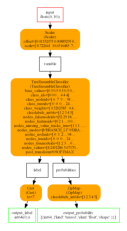

In [19]:
from pyquickhelper.helpgen.graphviz_helper import plot_graphviz
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(model_onnx)
ax = plot_graphviz(oinf.to_dot())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)